In [1]:
import pandas as pd

In [2]:
df1 = pd.read_csv('original_packets.csv')
df2 = pd.read_csv('flows_non_rygoristic.csv')
df3 = pd.read_csv('flows_rygoristic.csv')

In [3]:
df1.columns

Index(['ip.ttl', 'ip.proto', 'ip.len', 'tcp.seq', 'tcp.ack', 'tcp.len',
       'tcp.hdr_len', 'tcp.flags.fin', 'tcp.flags.syn', 'tcp.flags.reset',
       'tcp.flags.push', 'tcp.flags.ack', 'tcp.flags.urg', 'tcp.flags.cwr',
       'tcp.window_size', 'tcp.urgent_pointer', 'tcp.options.mss_val',
       'label'],
      dtype='object')

In [4]:
df2.columns

Index(['sizing_mean', 'sizing_min', 'sizing_max', 'sizing_std', 'deltas_mean',
       'deltas_min', 'deltas_max', 'deltas_std', 'fin', 'syn', 'rst', 'ack',
       'psh', 'urg', 'packet_count', 'label'],
      dtype='object')

In [5]:
to_drop = ["ip.ttl", "ip.proto", "tcp.seq", "tcp.ack", "tcp.hdr_len", "tcp.window_size", "tcp.options.mss_val", "tcp.flags.cwr", "tcp.urgent_pointer"]
df1 = df1.drop(columns=to_drop)
df1.columns

Index(['ip.len', 'tcp.len', 'tcp.flags.fin', 'tcp.flags.syn',
       'tcp.flags.reset', 'tcp.flags.push', 'tcp.flags.ack', 'tcp.flags.urg',
       'label'],
      dtype='object')

In [6]:
df1.label.value_counts()

label
1    366602
0    328261
Name: count, dtype: int64

In [7]:
df2.label.value_counts()

label
0    14545
1    10451
Name: count, dtype: int64

In [8]:
df3.label.value_counts()

label
1    46347
0    15379
Name: count, dtype: int64

In [9]:
datasets = {
    "Original packets": df1,
    "Flows non-rygoristic": df2,
    "Flows rygoristic": df3
}

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report

In [11]:
def calculate_metrics(y_true, y_pred, packet_counts=None):
    if packet_counts is None:
        packet_counts = [1] * len(y_true)

    weights = packet_counts

    cm = confusion_matrix(y_true, y_pred, sample_weight=weights)
    tn, fp, fn, tp = cm.ravel()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

    return f1, fpr

In [12]:
def train_model_and_evaluate(df, model_name):
    X = df.drop(columns=['label'])
    y = df['label']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    if model_name == 'Random Forest':
        model = RandomForestClassifier(random_state=42)
        param_grid = {
            'n_estimators': [10, 25, 50],
            'max_depth': [None, 10, 20, 30]
        }
    elif model_name == 'DNN':
        model = MLPClassifier(random_state=42, max_iter=500)
        param_grid = {
            'hidden_layer_sizes': [(25,), (50), (25, 25)],
            'activation': ['tanh', 'relu'],
            'solver': ['sgd', 'adam']
        }

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    print(f"Best parameters for {model_name} on {dataset_name}: {best_params}")

    y_pred = best_model.predict(X_test)

    packet_counts = X_test["packet_count"] if "packet_count" in X_test else None
    fscore, fpr = calculate_metrics(y_test, y_pred, packet_counts)

    return best_params, fscore, fpr

In [13]:
results = {'Dataset': [], 'Model_name': [], 'Params': [], 'FScore': [], 'FPR': []}

In [14]:
for dataset_name in datasets:
    for model_name in ['Random Forest', 'DNN']:
        print(dataset_name, model_name)
        params, fscore, fpr = train_model_and_evaluate(datasets[dataset_name], model_name)
        results['Dataset'].append(dataset_name)
        results['Model_name'].append(model_name)
        results['Params'].append(params)
        results['FScore'].append(fscore)
        results['FPR'].append(fpr)

Original packets Random Forest
Best parameters for Random Forest on Original packets: {'max_depth': None, 'n_estimators': 25}
Original packets DNN
Best parameters for DNN on Original packets: {'activation': 'tanh', 'hidden_layer_sizes': (25, 25), 'solver': 'adam'}
Flows non-rygoristic Random Forest
Best parameters for Random Forest on Flows non-rygoristic: {'max_depth': 10, 'n_estimators': 10}
Flows non-rygoristic DNN
Best parameters for DNN on Flows non-rygoristic: {'activation': 'tanh', 'hidden_layer_sizes': (25, 25), 'solver': 'adam'}
Flows rygoristic Random Forest
Best parameters for Random Forest on Flows rygoristic: {'max_depth': 30, 'n_estimators': 10}
Flows rygoristic DNN
Best parameters for DNN on Flows rygoristic: {'activation': 'tanh', 'hidden_layer_sizes': (25, 25), 'solver': 'adam'}


In [15]:
results

{'Dataset': ['Original packets',
  'Original packets',
  'Flows non-rygoristic',
  'Flows non-rygoristic',
  'Flows rygoristic',
  'Flows rygoristic'],
 'Model_name': ['Random Forest',
  'DNN',
  'Random Forest',
  'DNN',
  'Random Forest',
  'DNN'],
 'Params': [{'max_depth': None, 'n_estimators': 25},
  {'activation': 'tanh', 'hidden_layer_sizes': (25, 25), 'solver': 'adam'},
  {'max_depth': 10, 'n_estimators': 10},
  {'activation': 'tanh', 'hidden_layer_sizes': (25, 25), 'solver': 'adam'},
  {'max_depth': 30, 'n_estimators': 10},
  {'activation': 'tanh', 'hidden_layer_sizes': (25, 25), 'solver': 'adam'}],
 'FScore': [0.8914141414141414,
  0.8913300355389018,
  0.9999107128362474,
  0.9991078452841513,
  0.9955494330825474,
  0.9812403788452005],
 'FPR': [0.1343708676635134,
  0.1345844776726681,
  0.0,
  0.0034839527027027027,
  0.004763977558521958,
  0.03209034629522151]}

In [16]:
results_df = pd.DataFrame(results)

In [17]:
results_df

,Dataset,Model_name,Params,FScore,FPR
0,Original packets,Random Forest,"{'max_depth': None, 'n_estimators': 25}",0.891414,0.134371
1,Original packets,DNN,"{'activation': 'tanh', 'hidden_layer_sizes': (...",0.891330,0.134584
2,Flows non-rygoristic,Random Forest,"{'max_depth': 10, 'n_estimators': 10}",0.999911,0.000000
3,Flows non-rygoristic,DNN,"{'activation': 'tanh', 'hidden_layer_sizes': (...",0.999108,0.003484
4,Flows rygoristic,Random Forest,"{'max_depth': 30, 'n_estimators': 10}",0.995549,0.004764
5,Flows rygoristic,DNN,"{'activation': 'tanh', 'hidden_layer_sizes': (...",0.981240,0.032090


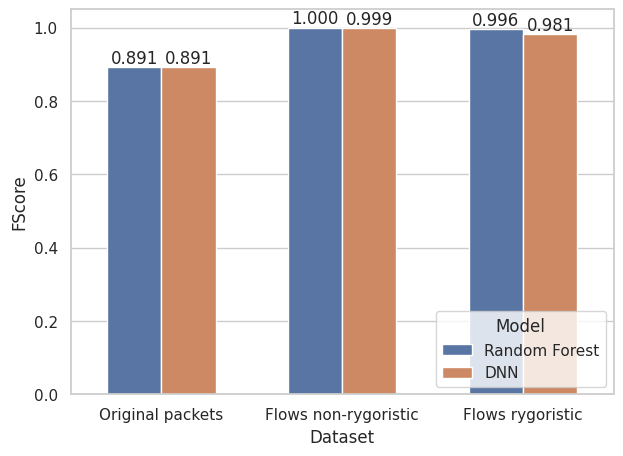

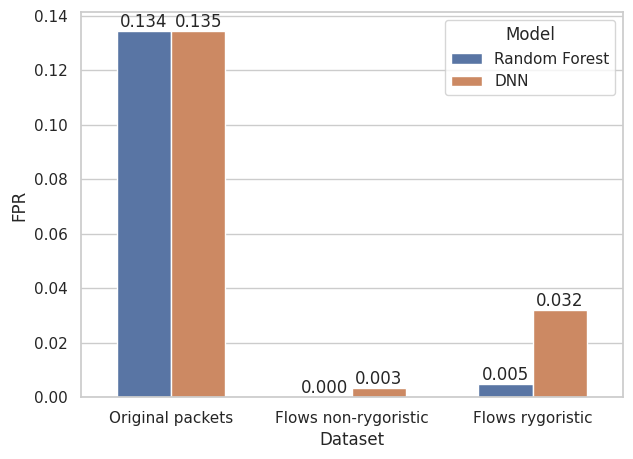

In [18]:
df_melted_fscore = pd.melt(results_df, id_vars=['Dataset', 'Model_name'], value_vars=['FScore'], var_name='Metric', value_name='Value')
df_melted_fpr = pd.melt(results_df, id_vars=['Dataset', 'Model_name'], value_vars=['FPR'], var_name='Metric', value_name='Value')


sns.set(style="whitegrid")

plt.figure(figsize=(7, 5))
ax = sns.barplot(x='Dataset', y='Value', hue='Model_name', data=df_melted_fscore, width=0.6)
for i in ax.containers:
    ax.bar_label(i,fmt="{:0.3f}")
plt.ylabel('FScore')
plt.xlabel('Dataset')
plt.legend(title='Model', loc='lower right')
plt.show()
print()

plt.figure(figsize=(7, 5))
ax = sns.barplot(x='Dataset', y='Value', hue='Model_name', data=df_melted_fpr, width=0.6)
for i in ax.containers:
    ax.bar_label(i,fmt="{:0.3f}")
plt.ylabel('FPR')
plt.xlabel('Dataset')
plt.legend(title='Model')
plt.show()